In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [3]:
score_files = ['designs_combined.sc'] # LIST SCORE FILES TO PROCESS
origins = ['design'] # LIST TAGS FOR EACH FILES SO YOU CAN DESTINGUSH THEM IN FINAL DATA

In [4]:
dfs = []
# read scores from different designs

for file, origin in zip(score_files, origins):   
    asdf = pd.read_csv(file, sep="\s+")
    asdf['origin'] = origin
    print(f'In file from {origin} found {asdf.shape[0]} designs')
    dfs.append(asdf)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)

df.head()

In file from design found 1689 designs


,SCORE:,score,fa_atr,fa_rep,fa_sol,fa_intra_atr_xover4,fa_intra_rep_xover4,fa_intra_sol_xover4,lk_ball,lk_ball_iso,...,sap_score_target,score_per_res,ss_sc,target_delta_sap,timed,interface_sc_int_area,interface_sc_median_dist,time,description,origin
0,SCORE:,-245.854,-1349.119,202.772,936.028,-83.732,32.252,58.668,500.203,-531.544,...,107.608,-2.163,0.798,15.859,419.0,779.879,0.617,429.0,mot_127_len_10_10_HHH_bc_00057_0001_0001,design
1,SCORE:,-170.391,-1366.598,209.731,962.881,-84.252,33.039,58.832,506.196,-536.778,...,107.738,-2.131,0.809,15.054,509.0,842.501,0.811,520.0,mot_127_len_10_10_HHH_bc_00137_0001_0001_0001,design
2,SCORE:,-219.139,-1375.267,213.610,943.979,-85.422,34.017,59.472,502.753,-536.051,...,106.245,-2.134,0.779,16.544,465.0,1095.913,0.772,477.0,mot_127_len_10_10_HHH_bc_00221_0001_0001_0001,design
3,SCORE:,-171.123,-1390.534,215.228,971.845,-86.995,34.632,61.589,523.052,-545.472,...,107.201,-2.210,0.828,17.208,406.0,1067.424,0.649,419.0,mot_127_len_10_10_HHH_bc_00258_0001_0003_0001,design
4,SCORE:,-222.042,-1366.664,206.497,954.605,-84.329,33.587,58.798,503.132,-537.576,...,107.846,-2.120,0.769,15.248,354.0,884.282,0.669,364.0,mot_127_len_10_10_HHH_bc_00482_0001_0001,design


In [5]:
def top_x_by_multiple(data, desired_num ):
    # creating lists where each design has it's rank within each term
    arg_sorted = np.argsort(data, axis=-1)
    ranked = np.zeros(arg_sorted.shape, np.int)
    for icol in range(len(ranked)):
        ranked[icol,arg_sorted[icol]] = np.arange(0, total, dtype=np.int)

    # first power of 2 where bigger_2 // 2 > total
    bigger_2 = 2**(np.floor(np.log(total)/np.log(2)).astype(int) + 2)
    assert( bigger_2 // 2 > total )

    percentiles = np.linspace(0, 1, bigger_2)

    space_size = bigger_2
    next_cut = bigger_2 // 2 - 1

    remaining = 0
    cutoff = total

    # binary search
    # We're trying to find a percentile where if we take everything better than
    #  that percentile from all categories, and look for members that exist in all
    #  lists, it's equal to the number of designs we want to keep
    while True:

        # this is the actual ranking process
        # take top X in each argsort and make sure they're in all top Xs
        eval_percentile = (percentiles[next_cut] + percentiles[next_cut+1]) / 2
        cutoff = eval_percentile * total

        mask = np.ones(total, np.bool)

        for icol in range(len(data)):
            mask &= ranked[icol] >= cutoff

        # end ranking


        remaining = mask.sum()

        # eprint(cutoff, next_cut, "/", bigger_2, remaining)

        if ( remaining == desired_num ):
            break

        space_size //= 2

        if ( space_size == 1 ):
            break

        if ( remaining < desired_num ):
            next_cut -= space_size // 2
        else:
            next_cut += space_size // 2
            
    print("Best effort == %ith percentile"%(eval_percentile*100))
            
    return mask


## Filtering

In [10]:
number_to_order = 1 #set the number of designs we want to filter

# All of the designs must pass these cutoffs
hard_cuts = {               # cutoff, higher is better
    'ddg' :                     [ -30,  False],
    'contact_molecular_surface':[ 450,  True],
    'score_per_res' :           [-2.4, False],
    'mismatch_probability':     [ 0.1, False],
    'sap_score':                [  35, False],
    'binder_delta_sap':         [  12,  True],
#    'ss_sc':                    [0.77, True], # optional
}

# After the hard cuts find the best by the following metrics

best_effort = {             # higher is better
    'ddg':                         [  False],
    'contact_patch' :               [  True],
    'target_delta_sap':             [  True],
    'contact_molec_sq5_apap_target':[  True],
}


########### Don't change stuff below here #############


score_df = df

# Print the pass rates for each term
print("")
print("=========================== Hard cuts: ===========================")
score_df['orderable'] = True
for pilot_term in hard_cuts:
    cut, higher_better = hard_cuts[pilot_term]
    ok_term = pilot_term.replace("_pilot", "") + "_ok"
    if ( higher_better ):
        score_df[ok_term] = score_df[pilot_term] >= cut
    else:
        score_df[ok_term] = score_df[pilot_term] <= cut
    score_df['orderable'] &= score_df[ok_term]
    print("%30s: %7.2f -- %5.0f%% pass-rate"%(pilot_term, cut, score_df[ok_term].sum() / len(score_df) * 100))


total = score_df['orderable'].sum()
print("")
print("                         %s (%.1f%%) designs remain"%(total, total/len(score_df)*100))

if ( total < number_to_order ):
    print("You don't have enough designs! Either change your cutoffs or go make some more!")
    assert(False)

after_hard_cuts = score_df[score_df['orderable']]
data = np.zeros((len(best_effort), total))
for iterm, term in enumerate(best_effort):
    higher_better = best_effort[term][0]
    if ( higher_better ):
        data[iterm] = after_hard_cuts[term].values
    else:
        data[iterm] = -after_hard_cuts[term].values

print(data)        
print("")
is_in_the_top = top_x_by_multiple(data, number_to_order )
final_df = after_hard_cuts[is_in_the_top]
        
print("")
print("=========================== Best effort: ===========================")
for term in best_effort:
    higher_better = best_effort[term]
    if ( higher_better ):
        cut = final_df[term].min()
        oks = (after_hard_cuts[term] >= cut).sum()
    else:
        cut = final_df[term].max()
        oks = (after_hard_cuts[term] <= cut).sum()
    
    print("%30s: %7.2f -- %5.0f%% pass-rate"%(term, cut, oks / len(after_hard_cuts) * 100))


print("")
print("Final: %i designs"%(len(final_df)))


=========================== Hard cuts: ===========================
                           ddg:  -30.00 --    47% pass-rate
     contact_molecular_surface:  450.00 --    47% pass-rate
                 score_per_res:   -2.40 --    12% pass-rate
          mismatch_probability:    0.10 --    23% pass-rate
                     sap_score:   35.00 --    98% pass-rate
              binder_delta_sap:   12.00 --     7% pass-rate

                         2 (0.1%) designs remain
[[  38.565   34.295]
 [ 150.583  193.775]
 [  15.773   16.456]
 [3444.938 3437.818]]

Best effort == 7th percentile

=========================== Best effort: ===========================
                           ddg:     nan --     0% pass-rate
                 contact_patch:     nan --     0% pass-rate
              target_delta_sap:     nan --     0% pass-rate
 contact_molec_sq5_apap_target:     nan --     0% pass-rate

Final: 0 designs


/var/folders/95/_sf15gzd0tn54994y567_dk40000gn/T/ipykernel_89277/1614490643.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ranked = np.zeros(arg_sorted.shape, np.int)
/var/folders/95/_sf15gzd0tn54994y567_dk40000gn/T/ipykernel_89277/1614490643.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review yo

### Visualization:

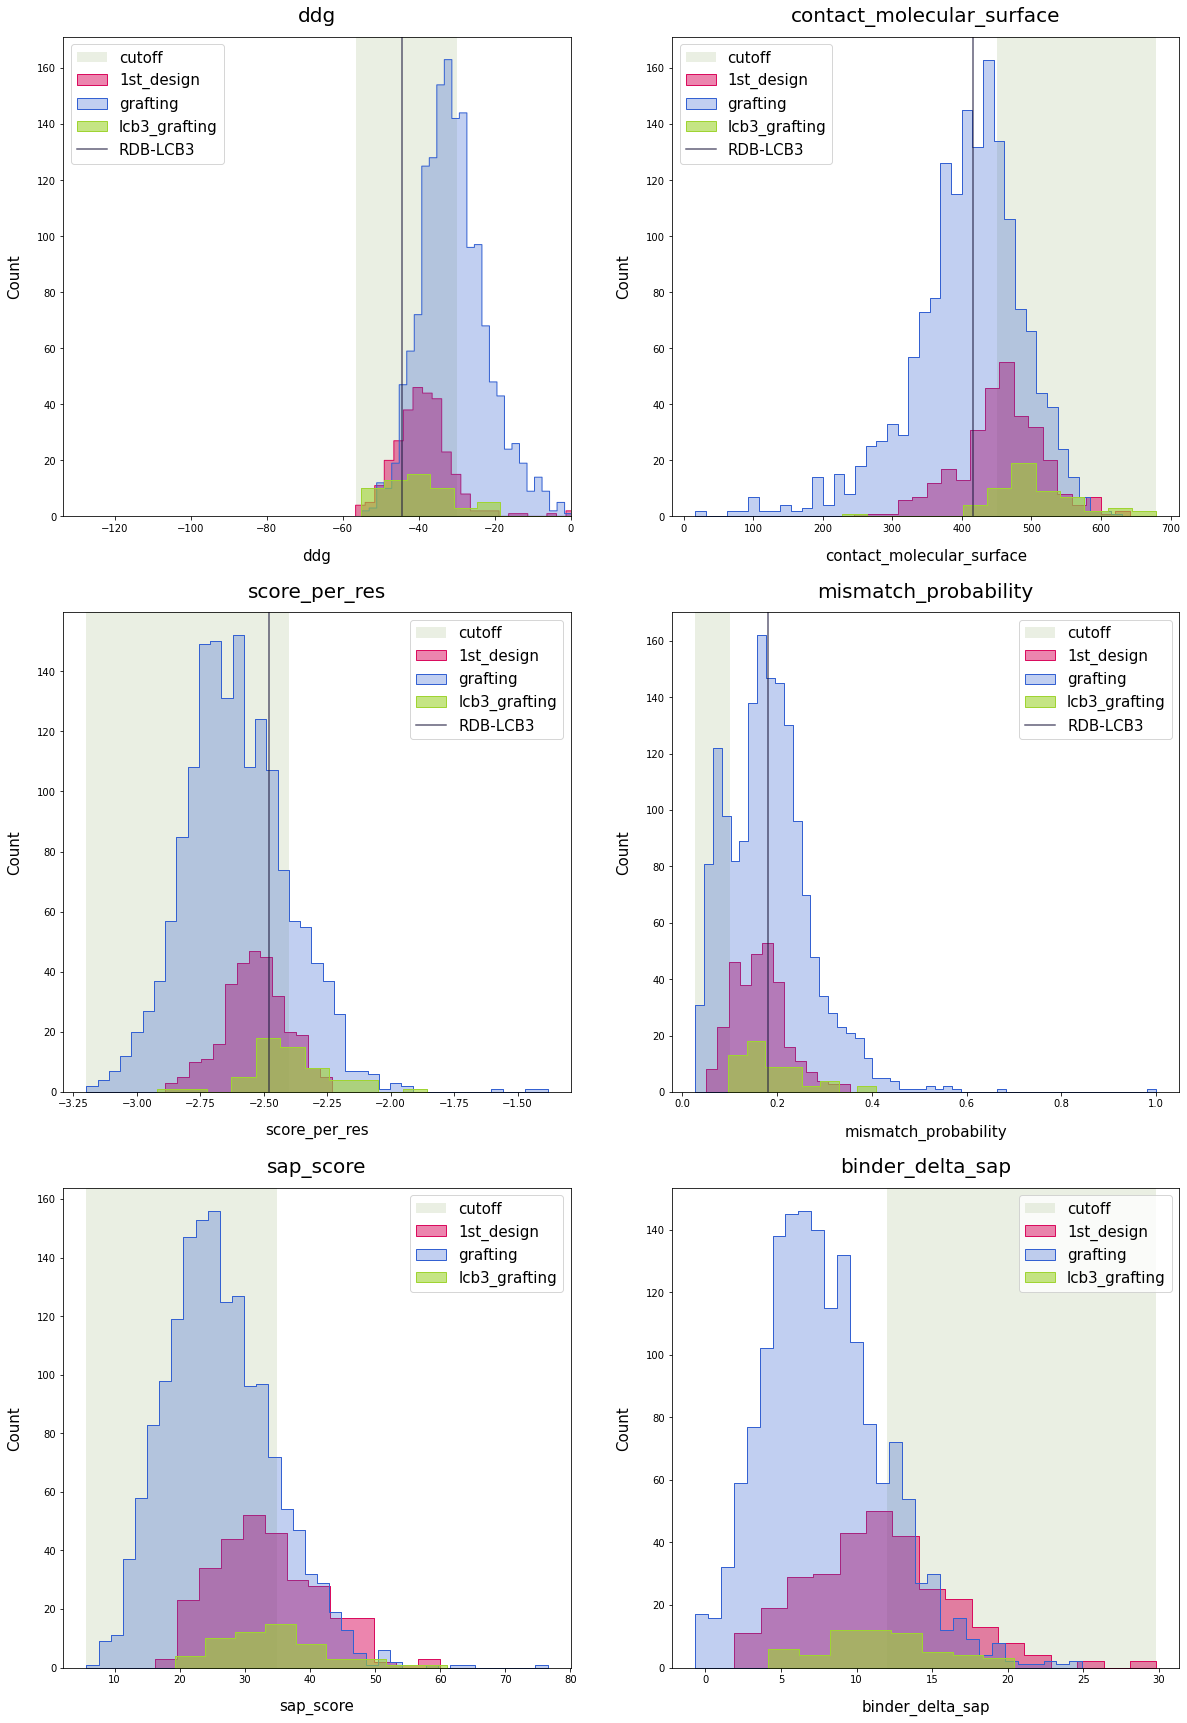

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(20, 30))
axes = axes.flatten()

for i, cut in enumerate(hard_cuts):
    
    # add cuts
    cutoff, higher_better = hard_cuts[cut]
    if higher_better:
        lim = df[cut].max()
        axes[i].axvspan(cutoff, lim, facecolor='#D6E1C9', alpha=0.5, label='cutoff')
    else:
        lim = df[cut].min()
        axes[i].axvspan(lim, cutoff, facecolor='#D6E1C9', alpha=0.5, label='cutoff')
    
    sns.histplot(df[cut], color='#da0c5e', label=origins[0], element="step", alpha=0.5,  ax=axes[i])
    
    axes[i].legend(fontsize=15, loc=l)
    axes[i].set_title(cut, fontsize=20, pad=15)
    axes[i].set_xlabel(xlabel=cut, fontsize=15, labelpad=15)
    axes[i].set_ylabel(ylabel='Count', fontsize=15, labelpad=15)

# plt.savefig("filter_plots_pred_scores.png", dpi = 300)
plt.show()

In [9]:
# save the list of filtered designs
output_name = "filtered_designs.list"
final_df[['description']].to_csv(output_name, index=None, header=None)

In [8]:
# view origins of the filtered designs
final_df[['origin', 'description']]

,origin,description
